# MCT Assignment 2 - Question 1 - Training a neural network to reproduce a double Exclusive Or (XOR) behaviour

## Truth Table For $A \oplus B \oplus C$
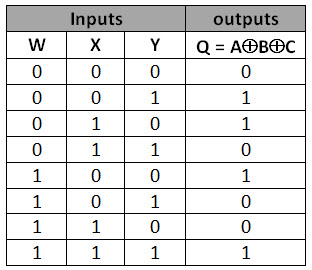

## Proposed Feed Forward Neural Network
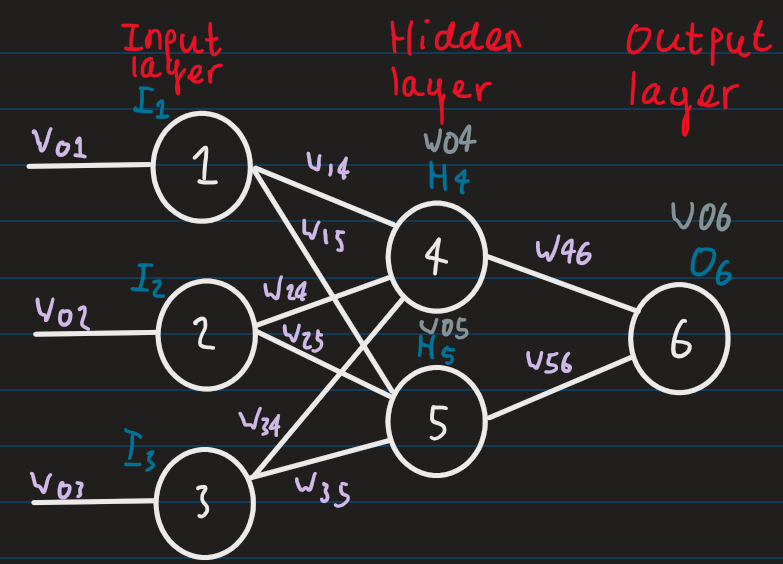

It is known that with continuous activitation functions for the neurons, parity problems can be solved with $n_{hidden}=n_{in}-1$ (also have been told so in the assignment)

## Imports
Numpy for maths

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

## Defining initial values and constants
### Weighting
$w = \left \{ w_{i, j} \right \}$

Where if $i = 0$ defines an implicit weighting for a node

$w_{0,1}, w_{0, 2}, w_{0, 3}$ are all equal to 1 as each input is equal in importance for the XOR problem

Weights are defined as random values between $\left [ -0.1, 0.1 \right ]$

Weight array is list of weights like so $\left [ w_{0,4}, w_{0,5}, w_{0,6}, w_{1,4}, w_{1,5}, w_{2,4}, w_{2,5}, w_{3,4}, w_{3,5}, w_{4,6}, w_{5,6}\right ]$

### Truth table
Truth table is determined in the TT variable, these are our input output functions.

Characterised by a set of input-output patterns, represented mathematically as $D_t=\left \{ x_p, t_p \right \}$ where $x_p$ and $t_p$ are input patterns and target output patterns respectively.

### Metropolis Parameters
Delta is our stepsize

Inverse temperature is beta

In [2]:
rng = np.random.default_rng() # Random number generator
k = 1.0
delta = 0.05 # stepsize
beta_0 = 5 #initial inverse temperature
beta = beta_0

n_out = 1
n_patts = 8

TT = [
    [0, 0, 0, 0],
    [0, 0, 1, 1],
    [0, 1, 0, 1],
    [0, 1, 1, 0],
    [1, 0, 0, 1],
    [1, 0, 1, 0],
    [1, 1, 0, 0],
    [1, 1, 1, 1]
]

## Defining our functions
### Energy (error) function
We first define an energy function - the output of which we hope to minimise - this can be defined multiple ways, two are defined below.
1. 
> $E(w)=(t_p-out_p)^2$ 
(as defined in neural network lecture notes) (Eq 1)
2. 
> $E(w)=\frac{\sum_p\left | out_p - t_p \right |^2}{n_{out}n_{patts}}$ 
(where $n_{out}$ and $n_{patts}$ are number of output nodes and patterns(number of rows in truth table)) (Eq 2)

It is important to note that the Metropolis algorithm is not dependent on the energy (error) function, thus any form of error function could be implemented.

For this implementation we go for the second function for error calculations.

### Introducing Boltzmann-Gibbs probability Distribution
A neural network with weights and patterns can be treated as a statistical system.

We introduce dynamics by demanding our system obeys Boltzmann-Gibbs probability dimension
> $P(\left \{ w_{i, j} \right \})=\frac{e^{-\beta E(w)}}{Z}$ (Eq 3)

Where the partition function, $Z$, is given by:
> $Z=\sum_{w_{i,j}}e^{-\beta E(w)}$ (Eq 4)

For a system obeying eq(3), as $\beta \rightarrow \infty$ energy approaches a minimum

### Calculating node input and output
To work out input for each hidden node:
> $X_i=w_{0i}+w_{1i}I_1+w_{2i}I_2+w_{3i}I_3$ for $I=4,5$

Output of each node in the hidden layer is given by:
> $H_h=\frac{1}{1+e^{-k\cdot X_h}}$ for $h=5, 6, 7$

Inputs to the output nodes given by:
> $X = w_{06} + w_{46}H_4 + w_{56}H_5$

Output node given by:
> $O=\frac{1}{1+e^{-k\cdot X}}$

In [3]:
def calcNodeOutput(x):
    return 1.0 / (1.0 + np.exp(-k * x))

def calcError(targets, outputs):
    sum = 0
    
    for i in range(len(targets)):
        sum += (outputs[i] - targets[i])**2
           
    return sum/(n_out * n_patts)

def network_test():
    correct = 0; err = 0.0
    
    targets=np.zeros(len(TT))
    outputs=np.zeros(len(TT))
    
    for i in range(len(TT)):
        i1=TT[i][0]; i2=TT[i][1]; i3=TT[i][2]
        h4=calcNodeOutput(w[0] + w[3]*i1 + w[5]*i2 + w[7]*i3)
        h5=calcNodeOutput(w[1] + w[4]*i1 + w[6]*i2 + w[8]*i3)
        o6=calcNodeOutput(w[2] + w[9]*h4 + w[10]*h5)
        targets[i] = TT[i][3]
        outputs[i] = o6
        if(int(round(o6)) == TT[i][3]):
            correct+=1
            
    err = calcError(targets, outputs)
    return correct, err

def beta_warming(error):    
    #return beta + np.exp(beta_0 / error)
    return np.exp(beta_0 / error)

def beta_cooling(error):
    print("beta cooling")
    
    cooled_value = np.log(beta_0 / error)
    return cooled_value

## Method (Metropolis algorithm)
Metropolis algorithm generates the next configuration by using the former one in the chain. Therefore, there is always a small correlation between subsequent configurations.

We can avoid this by using an N-hit Metropolis algorithm by measuring observables on every Nth interation.

The configuration is generated in the Basic Metropolis Update Step (BMUS).

The overall problem is solved in the Total Update Algorithm (TUA).

### Total-Update Algorithm (TUA):
1. Set stepsize $\delta$ (learning rate) and inverse temperature $\beta$
2. Initialise network by generating weights uniformly in a range, in this case $\left [ -0.1, 0.1 \right ]$
3. Perform 10 BMUS as explained below and measure observables on the Nth iteration (measuring energy of the network)
4. Check for the last 30 TUA iterations that the energy of the system is getting smaller
> if it is then heat the system by increasing beta such that it tends to infinity as the error of the system reaches a minimum - meaning less statistical fluctuations occur
> if it isn't then cool the system by decreasing beta - allowing more random statistical fluctuations to occur
5. If cooling has occurred check that it has worked, if it hasn't reset the weights of the system - this is because the energy has reached a minimum that doesn't provide the correct answer
6. Repeat steps 3-5 for selected number of TUA iterations

### Basic Metropolis Update Step (BMUS)
1. Loop over all weights $w_{i, j}$ in network and for each do the following
2. Draw random number uniformly between $-1.0$ and $1.0$ such that 
> $r \in U (-1, 1)$
3. Propose change in given weight by
> $w_{i, j} = w_{i, j} + r \cdot\delta$
4. Compute new energy $E'$ of network, and compare with current energy $E_0$
5. If $\Delta E = E' - E_0 < 0$ accept change ($E_0=E'$), else draw number $p\in U(0, 1)$ and accept change if $p < e^{-\beta \Delta E}$ ($E_0=E'$) else reject proposed change and keep old value ($E_0 = E_0$)

### Observations of algorithm
This means the algorithm will always accept weight-changes that decrease energy, but also accepts some weight changes that increase the energy.

The reasoning for this is that this will introduce statistical fluctuations into the system.

In [4]:
def BMUS(error_0):
    for i in range(len(w)):
        old_weight = w[i]
        r = 2.0 * rng.random(size=1)[0] - 1.0
        
        w[i] = w[i] + r * delta
        new_correct, new_error = network_test()
        
        delta_E = new_error - error_0
        
        if(delta_E > 0): # if error has gotten larger
            p = rng.random(size=1)[0]
            if(p > np.exp(-beta * delta_E)): # if statistical fluctuation is not allowed
                w[i] = old_weight

# initialise beta and weights
beta = beta_0
w = (2.0 * rng.random(size=11) - 1.0)
print("inital weights are: ", w)

# initialise variables needed for looping/outputs
n_correct = 0
N_BMU_iterations = 10
tua_n = 2000
bmus_n = 0
n_cooling = 0
n_actual_cooling = 0
n_reset = 0
correct_found = -1
errors = np.zeros(tua_n)
iteration = np.linspace(1, tua_n, tua_n)
n_since_last_cool = -1

while(n_correct != 8): # TODO implement this correctly

    for i in range(tua_n):

        n_correct, error_0 = network_test()
        errors[i] = error_0

        # record when correct value was found
        if(n_correct == 8 and correct_found == -1):
             correct_found = i+1

        # for first 200 iterations don't allow beta cooling, only warm beta
        if(i < 200):
            # warm beta value
            beta = beta_warming(errors[i])
        else:
            # calculate the mean and variation for the last 30 error values
            prev_30_errors = errors[i-29:i]
            mean = np.mean(prev_30_errors)
            var = np.var(prev_30_errors)

            # if there has recently been cooling, add one to the counter for how many iterations
            # it has been since last cool
            if(n_since_last_cool > -1):
                        n_since_last_cool += 1

            # if error value hasn't changed enough to go above the threshold var/mean value, we haven't already got the correct answer
            # we haven't already cooled for these weight values and there hasn't recently been a cooling from last set of weights
            # then start cooling
            if(var/mean < 0.000000001 and n_correct != 8 and n_cooling < 1 and (n_since_last_cool > 250 or n_since_last_cool == -1)): #0.000001%
                n_cooling += 1
                n_actual_cooling += 1

                beta = beta_cooling(errors[i])
                n_since_last_cool = 0

            # if there's been cooling and it hasn't worked then reset weights and beta value
            elif(var/mean < 0.00000001 and n_since_last_cool > 200 and n_correct != 8 and n_cooling == 1):
                print("Resetting weights")
                w = (2.0 * rng.random(size=11) - 1.0)
                beta=beta_0
                n_cooling = 0
                n_reset += 1

            # if cooling has ended/not happened then just warm value as per norm
            elif(n_since_last_cool > 100 or n_since_last_cool == -1):
                #delta_E = np.absolute(errors[i] - errors[i-1])
                beta = beta_warming(errors[i])
            # if cooling has recently started continue cooling beta value
            elif(n_since_last_cool < 50):
                #delta_E = np.absolute(errors[i] - errors[i-1])
                beta = beta_cooling(errors[i])

        # for number of BMU iterations complete a BMUS without checking error value
        for j in range(N_BMU_iterations):
            BMUS(error_0)
            bmus_n += 1

        print("Iteration", i+1)
        print(network_test()) 
        print("Inverse Temperature - ", beta)


print("Initial Neural Network completed")
#print("There were", tua_n, "completed TUA iterations")
#print("There were", bmus_n, "completed BMUS iterations")
print("Beta was cooled", n_actual_cooling, "times")
if(correct_found == -1):
    print("The correct truth table was not reproduced")
else:
    print("The correct truth table was found in", correct_found, "iterations")
print("Final error was", errors[-1])
print("The weights and beta was reset", n_reset, "times")

inital weights are:  [-0.92746089 -0.5294867   0.38760328  0.84478216 -0.09179224 -0.00165167
 -0.85474562  0.97385841  0.17366067  0.23462797  0.93890169]
Iteration 1
(4, 0.27978550628740234)
Inverse Temperature -  42233741.63313837
Iteration 2
(4, 0.2755278880346488)
Inverse Temperature -  57703754.013733275
Iteration 3
(4, 0.26746424244299805)
Inverse Temperature -  76056220.04756275
Iteration 4
(4, 0.25819651814936073)
Inverse Temperature -  131443502.94868517
Iteration 5
(4, 0.2530202512008537)
Inverse Temperature -  257130578.79069465
Iteration 6
(4, 0.2508099476318903)
Inverse Temperature -  382127191.732969
Iteration 7
(4, 0.2505492747889909)
Inverse Temperature -  454820519.4676045
Iteration 8
(5, 0.2504499579969591)
Inverse Temperature -  464352421.09692514
Iteration 9
(4, 0.25037936836106944)
Inverse Temperature -  468041737.1028319
Iteration 10
(4, 0.25037191638035206)
Inverse Temperature -  470683530.24828357
Iteration 11
(3, 0.2501422167687248)
Inverse Temperature -  4709

Iteration 120
(6, 0.18677696062078084)
Inverse Temperature -  411515036898.5344
Iteration 121
(6, 0.18626726034765448)
Inverse Temperature -  422686671340.3341
Iteration 122
(6, 0.1858180284604397)
Inverse Temperature -  454811983970.6255
Iteration 123
(6, 0.18375882424033965)
Inverse Temperature -  485306113608.95056
Iteration 124
(6, 0.1829823806244154)
Inverse Temperature -  656099089865.0138
Iteration 125
(6, 0.18284553422106045)
Inverse Temperature -  736397024889.6061
Iteration 126
(6, 0.182103416959506)
Inverse Temperature -  751611962765.2927
Iteration 127
(6, 0.17905328865135775)
Inverse Temperature -  840216773728.6823
Iteration 128
(6, 0.17830193875718486)
Inverse Temperature -  1341282915401.2295
Iteration 129
(6, 0.17805906672964672)
Inverse Temperature -  1508776041624.7227
Iteration 130
(6, 0.1768974780547838)
Inverse Temperature -  1567604084660.9495
Iteration 131
(6, 0.1765885587683993)
Inverse Temperature -  1885019348294.2183
Iteration 132
(6, 0.17592067970706946)
In

Iteration 221
(7, 0.10537084289356963)
Inverse Temperature -  1.8651188559331407e+20
Iteration 222
(8, 0.10528332512628662)
Inverse Temperature -  4.0542063393322854e+20
Iteration 223
(7, 0.10495521461797076)
Inverse Temperature -  4.217318164957514e+20
Iteration 224
(7, 0.10468751813067584)
Inverse Temperature -  4.8923132889049766e+20
Iteration 225
(7, 0.10379399073406119)
Inverse Temperature -  5.526108707316264e+20
Iteration 226
(8, 0.10205441987224806)
Inverse Temperature -  8.336502876436314e+20
Iteration 227
(8, 0.10136790418952442)
Inverse Temperature -  1.894929235747566e+21
Iteration 228
(7, 0.1012634033274824)
Inverse Temperature -  2.640558664767102e+21
Iteration 229
(8, 0.10124579383617073)
Inverse Temperature -  2.778448698361291e+21
Iteration 230
(7, 0.10092663578766589)
Inverse Temperature -  2.8024125080982735e+21
Iteration 231
(7, 0.10032314423550505)
Inverse Temperature -  3.2760846496705985e+21
Iteration 232
(8, 0.09953178334626955)
Inverse Temperature -  4.41347057

Iteration 323
(8, 0.05534603878611355)
Inverse Temperature -  1.0122190177603564e+39
Iteration 324
(8, 0.0551504100658617)
Inverse Temperature -  1.7158068389669913e+39
Iteration 325
(8, 0.054970127827934076)
Inverse Temperature -  2.3639610767641597e+39
Iteration 326
(8, 0.054825220367114805)
Inverse Temperature -  3.182524040044095e+39
Iteration 327
(8, 0.05445510604838004)
Inverse Temperature -  4.0474425331402367e+39
Iteration 328
(8, 0.05425488136034976)
Inverse Temperature -  7.522779054504968e+39
Iteration 329
(8, 0.05406124040151883)
Inverse Temperature -  1.0556985169036611e+40
Iteration 330
(8, 0.05366730557273909)
Inverse Temperature -  1.4685863594504264e+40
Iteration 331
(8, 0.05344143616851507)
Inverse Temperature -  2.8955902830216993e+40
Iteration 332
(8, 0.05301158144551448)
Inverse Temperature -  4.292872770002253e+40
Iteration 333
(8, 0.052683842473728544)
Inverse Temperature -  9.166985845694995e+40
Iteration 334
(8, 0.05219394174408194)
Inverse Temperature -  1.648

Iteration 422
(8, 0.02070300529428821)
Inverse Temperature -  4.169977322007451e+103
Iteration 423
(8, 0.020567948584203286)
Inverse Temperature -  7.70585715624899e+104
Iteration 424
(8, 0.020484998597869137)
Inverse Temperature -  3.763105303444774e+105
Iteration 425
(8, 0.02029499669049766)
Inverse Temperature -  1.0070565335878272e+106
Iteration 426
(8, 0.0202572908431879)
Inverse Temperature -  9.895898141628304e+106
Iteration 427
(8, 0.019953212157797898)
Inverse Temperature -  1.5653479355745742e+107
Iteration 428
(8, 0.019856231700145093)
Inverse Temperature -  6.733057713523388e+108
Iteration 429
(8, 0.019693361060345426)
Inverse Temperature -  2.2895160744357836e+109
Iteration 430
(8, 0.01942801706291063)
Inverse Temperature -  1.8373213265744816e+110
Iteration 431
(8, 0.0193538677587377)
Inverse Temperature -  5.890490380634403e+111
Iteration 432
(8, 0.019254620313505503)
Inverse Temperature -  1.5789547320487167e+112
Iteration 433
(8, 0.018932692218100525)
Inverse Temperatu

<ipython-input-3-9c694ee56db4>:33: RuntimeWarning: overflow encountered in exp
  return np.exp(beta_0 / error)


 534
(8, 0.006384285466987093)
Inverse Temperature -  inf
Iteration 535
(8, 0.006283789697542097)
Inverse Temperature -  inf
Iteration 536
(8, 0.006208260795241856)
Inverse Temperature -  inf
Iteration 537
(8, 0.006125898634270322)
Inverse Temperature -  inf
Iteration 538
(8, 0.006125092913985883)
Inverse Temperature -  inf
Iteration 539
(8, 0.006082782215857975)
Inverse Temperature -  inf
Iteration 540
(8, 0.006055764073237199)
Inverse Temperature -  inf
Iteration 541
(8, 0.005842837384537232)
Inverse Temperature -  inf
Iteration 542
(8, 0.0058303262752227945)
Inverse Temperature -  inf
Iteration 543
(8, 0.00582845384962492)
Inverse Temperature -  inf
Iteration 544
(8, 0.0056856137415449435)
Inverse Temperature -  inf
Iteration 545
(8, 0.005583654948914316)
Inverse Temperature -  inf
Iteration 546
(8, 0.005570423353933903)
Inverse Temperature -  inf
Iteration 547
(8, 0.005490346123056316)
Inverse Temperature -  inf
Iteration 548
(8, 0.005481312466586671)
Inverse Temperature -  inf
Ite

Iteration 675
(8, 0.0013443508934334186)
Inverse Temperature -  inf
Iteration 676
(8, 0.001324493079552053)
Inverse Temperature -  inf
Iteration 677
(8, 0.0013154195347781803)
Inverse Temperature -  inf
Iteration 678
(8, 0.0012979661540064179)
Inverse Temperature -  inf
Iteration 679
(8, 0.0012975205711441742)
Inverse Temperature -  inf
Iteration 680
(8, 0.0012828477106873607)
Inverse Temperature -  inf
Iteration 681
(8, 0.001251894172412118)
Inverse Temperature -  inf
Iteration 682
(8, 0.0012413431095144715)
Inverse Temperature -  inf
Iteration 683
(8, 0.0012319389847925799)
Inverse Temperature -  inf
Iteration 684
(8, 0.0012178012559041385)
Inverse Temperature -  inf
Iteration 685
(8, 0.0012111610500315567)
Inverse Temperature -  inf
Iteration 686
(8, 0.0012066532776798375)
Inverse Temperature -  inf
Iteration 687
(8, 0.001170575662886997)
Inverse Temperature -  inf
Iteration 688
(8, 0.0011657521200667226)
Inverse Temperature -  inf
Iteration 689
(8, 0.0011551796254776962)
Inverse Te

(8, 0.00034721523320255417)
Inverse Temperature -  inf
Iteration 800
(8, 0.00033437447433898424)
Inverse Temperature -  inf
Iteration 801
(8, 0.0003333840268383573)
Inverse Temperature -  inf
Iteration 802
(8, 0.0003308374395687726)
Inverse Temperature -  inf
Iteration 803
(8, 0.00032609627340784736)
Inverse Temperature -  inf
Iteration 804
(8, 0.00032513637235250404)
Inverse Temperature -  inf
Iteration 805
(8, 0.0003247373024907477)
Inverse Temperature -  inf
Iteration 806
(8, 0.00032247820354752525)
Inverse Temperature -  inf
Iteration 807
(8, 0.00031882902691637534)
Inverse Temperature -  inf
Iteration 808
(8, 0.0003184584067609912)
Inverse Temperature -  inf
Iteration 809
(8, 0.000315466567731904)
Inverse Temperature -  inf
Iteration 810
(8, 0.00031544612980795837)
Inverse Temperature -  inf
Iteration 811
(8, 0.00030800757501158805)
Inverse Temperature -  inf
Iteration 812
(8, 0.00029931814052373384)
Inverse Temperature -  inf
Iteration 813
(8, 0.0002942274986546785)
Inverse Tempe

Iteration 930
(8, 6.382312053850611e-05)
Inverse Temperature -  inf
Iteration 931
(8, 6.18665590929069e-05)
Inverse Temperature -  inf
Iteration 932
(8, 6.1851663661712e-05)
Inverse Temperature -  inf
Iteration 933
(8, 6.126319947602806e-05)
Inverse Temperature -  inf
Iteration 934
(8, 6.107439278063661e-05)
Inverse Temperature -  inf
Iteration 935
(8, 6.015600770378104e-05)
Inverse Temperature -  inf
Iteration 936
(8, 5.990644567749944e-05)
Inverse Temperature -  inf
Iteration 937
(8, 5.946389377862043e-05)
Inverse Temperature -  inf
Iteration 938
(8, 5.9454842930365214e-05)
Inverse Temperature -  inf
Iteration 939
(8, 5.867023686932947e-05)
Inverse Temperature -  inf
Iteration 940
(8, 5.8558975188580574e-05)
Inverse Temperature -  inf
Iteration 941
(8, 5.7974057541009566e-05)
Inverse Temperature -  inf
Iteration 942
(8, 5.795481052239513e-05)
Inverse Temperature -  inf
Iteration 943
(8, 5.731814564650352e-05)
Inverse Temperature -  inf
Iteration 944
(8, 5.607995088358606e-05)
Inverse

Iteration 1055
(8, 1.3991579934526437e-05)
Inverse Temperature -  inf
Iteration 1056
(8, 1.3902944911889764e-05)
Inverse Temperature -  inf
Iteration 1057
(8, 1.3801400838203997e-05)
Inverse Temperature -  inf
Iteration 1058
(8, 1.3674802562177302e-05)
Inverse Temperature -  inf
Iteration 1059
(8, 1.358785714946482e-05)
Inverse Temperature -  inf
Iteration 1060
(8, 1.3501859612631036e-05)
Inverse Temperature -  inf
Iteration 1061
(8, 1.3341849278516455e-05)
Inverse Temperature -  inf
Iteration 1062
(8, 1.3264765083056083e-05)
Inverse Temperature -  inf
Iteration 1063
(8, 1.3103178209493494e-05)
Inverse Temperature -  inf
Iteration 1064
(8, 1.2997207623563235e-05)
Inverse Temperature -  inf
Iteration 1065
(8, 1.2994251889894244e-05)
Inverse Temperature -  inf
Iteration 1066
(8, 1.254285264829822e-05)
Inverse Temperature -  inf
Iteration 1067
(8, 1.2211959206998885e-05)
Inverse Temperature -  inf
Iteration 1068
(8, 1.2190641638637703e-05)
Inverse Temperature -  inf
Iteration 1069
(8, 1.1

Iteration 1182
(8, 2.6533134015887564e-06)
Inverse Temperature -  inf
Iteration 1183
(8, 2.647068933814652e-06)
Inverse Temperature -  inf
Iteration 1184
(8, 2.5954410677315105e-06)
Inverse Temperature -  inf
Iteration 1185
(8, 2.54785130126649e-06)
Inverse Temperature -  inf
Iteration 1186
(8, 2.5362638003015917e-06)
Inverse Temperature -  inf
Iteration 1187
(8, 2.4547934892807704e-06)
Inverse Temperature -  inf
Iteration 1188
(8, 2.413421102861701e-06)
Inverse Temperature -  inf
Iteration 1189
(8, 2.344472440170925e-06)
Inverse Temperature -  inf
Iteration 1190
(8, 2.338357761619928e-06)
Inverse Temperature -  inf
Iteration 1191
(8, 2.323695490215259e-06)
Inverse Temperature -  inf
Iteration 1192
(8, 2.3081709046068683e-06)
Inverse Temperature -  inf
Iteration 1193
(8, 2.2600554644457257e-06)
Inverse Temperature -  inf
Iteration 1194
(8, 2.251873059552669e-06)
Inverse Temperature -  inf
Iteration 1195
(8, 2.245480792278324e-06)
Inverse Temperature -  inf
Iteration 1196
(8, 2.23950027

Iteration 1310
(8, 5.554642302908851e-07)
Inverse Temperature -  inf
Iteration 1311
(8, 5.488968593109102e-07)
Inverse Temperature -  inf
Iteration 1312
(8, 5.299015021215982e-07)
Inverse Temperature -  inf
Iteration 1313
(8, 5.159272487500246e-07)
Inverse Temperature -  inf
Iteration 1314
(8, 5.082732725808397e-07)
Inverse Temperature -  inf
Iteration 1315
(8, 5.049252243387587e-07)
Inverse Temperature -  inf
Iteration 1316
(8, 4.95528854128409e-07)
Inverse Temperature -  inf
Iteration 1317
(8, 4.948640616443965e-07)
Inverse Temperature -  inf
Iteration 1318
(8, 4.941018774674821e-07)
Inverse Temperature -  inf
Iteration 1319
(8, 4.835364112916069e-07)
Inverse Temperature -  inf
Iteration 1320
(8, 4.803419460547778e-07)
Inverse Temperature -  inf
Iteration 1321
(8, 4.777259392238961e-07)
Inverse Temperature -  inf
Iteration 1322
(8, 4.752037721514615e-07)
Inverse Temperature -  inf
Iteration 1323
(8, 4.5922047660970314e-07)
Inverse Temperature -  inf
Iteration 1324
(8, 4.5816519391449

Iteration 1445
(8, 1.0856559494106539e-07)
Inverse Temperature -  inf
Iteration 1446
(8, 1.0661301497121192e-07)
Inverse Temperature -  inf
Iteration 1447
(8, 1.0623698073861959e-07)
Inverse Temperature -  inf
Iteration 1448
(8, 1.049538347536281e-07)
Inverse Temperature -  inf
Iteration 1449
(8, 1.036336776286569e-07)
Inverse Temperature -  inf
Iteration 1450
(8, 1.0181963279086584e-07)
Inverse Temperature -  inf
Iteration 1451
(8, 1.0061320233702384e-07)
Inverse Temperature -  inf
Iteration 1452
(8, 9.990076183908515e-08)
Inverse Temperature -  inf
Iteration 1453
(8, 9.825198715452743e-08)
Inverse Temperature -  inf
Iteration 1454
(8, 9.746302656943588e-08)
Inverse Temperature -  inf
Iteration 1455
(8, 9.474242725505085e-08)
Inverse Temperature -  inf
Iteration 1456
(8, 9.460132994289573e-08)
Inverse Temperature -  inf
Iteration 1457
(8, 9.43700441163748e-08)
Inverse Temperature -  inf
Iteration 1458
(8, 9.39628620401751e-08)
Inverse Temperature -  inf
Iteration 1459
(8, 9.1625137170

Iteration 1570
(8, 2.10392186806282e-08)
Inverse Temperature -  inf
Iteration 1571
(8, 2.0849541749651155e-08)
Inverse Temperature -  inf
Iteration 1572
(8, 2.0809543469836678e-08)
Inverse Temperature -  inf
Iteration 1573
(8, 2.0719548970435865e-08)
Inverse Temperature -  inf
Iteration 1574
(8, 2.0582823472524453e-08)
Inverse Temperature -  inf
Iteration 1575
(8, 2.0447639677556613e-08)
Inverse Temperature -  inf
Iteration 1576
(8, 2.043545277542321e-08)
Inverse Temperature -  inf
Iteration 1577
(8, 1.9867389632569942e-08)
Inverse Temperature -  inf
Iteration 1578
(8, 1.9736528623424238e-08)
Inverse Temperature -  inf
Iteration 1579
(8, 1.958451805977623e-08)
Inverse Temperature -  inf
Iteration 1580
(8, 1.958091057188945e-08)
Inverse Temperature -  inf
Iteration 1581
(8, 1.9389147155111982e-08)
Inverse Temperature -  inf
Iteration 1582
(8, 1.9353921852328647e-08)
Inverse Temperature -  inf
Iteration 1583
(8, 1.8907990416399673e-08)
Inverse Temperature -  inf
Iteration 1584
(8, 1.8776

Inverse Temperature -  inf
Iteration 1692
(8, 4.9518315995962965e-09)
Inverse Temperature -  inf
Iteration 1693
(8, 4.8894962419312164e-09)
Inverse Temperature -  inf
Iteration 1694
(8, 4.846315729921021e-09)
Inverse Temperature -  inf
Iteration 1695
(8, 4.822989889938209e-09)
Inverse Temperature -  inf
Iteration 1696
(8, 4.735129274624586e-09)
Inverse Temperature -  inf
Iteration 1697
(8, 4.716172581424746e-09)
Inverse Temperature -  inf
Iteration 1698
(8, 4.6625910079593226e-09)
Inverse Temperature -  inf
Iteration 1699
(8, 4.586901910321293e-09)
Inverse Temperature -  inf
Iteration 1700
(8, 4.5210221846272305e-09)
Inverse Temperature -  inf
Iteration 1701
(8, 4.487005115644964e-09)
Inverse Temperature -  inf
Iteration 1702
(8, 4.470162635840504e-09)
Inverse Temperature -  inf
Iteration 1703
(8, 4.351072796617712e-09)
Inverse Temperature -  inf
Iteration 1704
(8, 4.335848856320042e-09)
Inverse Temperature -  inf
Iteration 1705
(8, 4.187243851239362e-09)
Inverse Temperature -  inf
Ite

Iteration 1823
(8, 1.2122505232047587e-09)
Inverse Temperature -  inf
Iteration 1824
(8, 1.2021838822111909e-09)
Inverse Temperature -  inf
Iteration 1825
(8, 1.1979048795519913e-09)
Inverse Temperature -  inf
Iteration 1826
(8, 1.1838547732240838e-09)
Inverse Temperature -  inf
Iteration 1827
(8, 1.149013750415257e-09)
Inverse Temperature -  inf
Iteration 1828
(8, 1.1431977569825606e-09)
Inverse Temperature -  inf
Iteration 1829
(8, 1.1360907029110667e-09)
Inverse Temperature -  inf
Iteration 1830
(8, 1.1074789974001811e-09)
Inverse Temperature -  inf
Iteration 1831
(8, 1.0885298647800662e-09)
Inverse Temperature -  inf
Iteration 1832
(8, 1.0823226637282324e-09)
Inverse Temperature -  inf
Iteration 1833
(8, 1.0786831190343732e-09)
Inverse Temperature -  inf
Iteration 1834
(8, 1.073197089506756e-09)
Inverse Temperature -  inf
Iteration 1835
(8, 1.0681080608552392e-09)
Inverse Temperature -  inf
Iteration 1836
(8, 1.0626709000641577e-09)
Inverse Temperature -  inf
Iteration 1837
(8, 1.0

Iteration 1953
(8, 2.7696424098705773e-10)
Inverse Temperature -  inf
Iteration 1954
(8, 2.760537598307788e-10)
Inverse Temperature -  inf
Iteration 1955
(8, 2.746837637003074e-10)
Inverse Temperature -  inf
Iteration 1956
(8, 2.7424443696303404e-10)
Inverse Temperature -  inf
Iteration 1957
(8, 2.741499902274439e-10)
Inverse Temperature -  inf
Iteration 1958
(8, 2.6759028115626554e-10)
Inverse Temperature -  inf
Iteration 1959
(8, 2.628727735738713e-10)
Inverse Temperature -  inf
Iteration 1960
(8, 2.6169223779668765e-10)
Inverse Temperature -  inf
Iteration 1961
(8, 2.604117005277973e-10)
Inverse Temperature -  inf
Iteration 1962
(8, 2.565660271225505e-10)
Inverse Temperature -  inf
Iteration 1963
(8, 2.546291674937614e-10)
Inverse Temperature -  inf
Iteration 1964
(8, 2.521337803107882e-10)
Inverse Temperature -  inf
Iteration 1965
(8, 2.502904933444398e-10)
Inverse Temperature -  inf
Iteration 1966
(8, 2.42550131104298e-10)
Inverse Temperature -  inf
Iteration 1967
(8, 2.3817877182

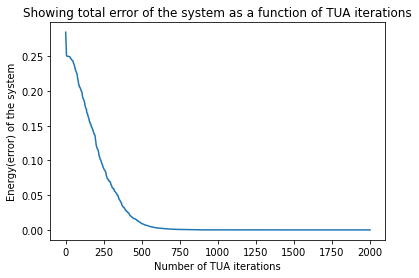

In [5]:
plt.plot(iteration, errors)
plt.xlabel("Number of TUA iterations")
plt.ylabel("Energy(error) of the system")
plt.title("Showing total error of the system as a function of TUA iterations")
plt.show()

In [6]:
# final outputs
print ("  X1   X2   X3   |  target   actual ")
for i in range(len(TT)):
    i1=TT[i][0]; i2=TT[i][1]; i3=TT[i][2]
    h4=calcNodeOutput(w[0] + w[3]*i1 + w[5]*i2 + w[7]*i3)
    h5=calcNodeOutput(w[1] + w[4]*i1 + w[6]*i2 + w[8]*i3)
    o6=calcNodeOutput(w[2] + w[9]*h4 + w[10]*h5)
    
    print(" ",TT[i][0], "  ", TT[i][1],"  ", TT[i][2], "   |   " , TT[i][3], "    " , o6)

  X1   X2   X3   |  target   actual 
  0    0    0    |    0      1.865987944015487e-05
  0    0    1    |    1      0.9999890256352025
  0    1    0    |    1      0.9999888439238948
  0    1    1    |    0      1.1035800322445447e-05
  1    0    0    |    1      0.9999896064890955
  1    0    1    |    0      1.186143513223118e-05
  1    1    0    |    0      1.1621680119483612e-05
  1    1    1    |    1      0.9999876399958532
